## Import modules

In [1]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# model
from sklearn.svm import SVC

## Prepare graphics

In [2]:
def plot_roc(pipe, Xtest, ytest):
    yscores = pipe.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

## Prepare f2 metric

In [3]:
from sklearn.metrics import make_scorer,fbeta_score
def f2_score(y_true, y_pred):
    score = fbeta_score(y_true, y_pred, beta=2)
    return score

def f2():
    return make_scorer(f2_score)

## Load, clean and split the data

In [4]:
raw_data = pd.read_csv("../Data/HR_Analytics.csv")

In [5]:
# Assign columns to column groups
catcols = ["AgeGroup", "SalarySlab", "Department", "EducationField", "JobRole", "MaritalStatus"]
numcols = ["Education", "EnvironmentSatisfaction", "BusinessTravel", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", 
           "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance", "OverTime", "Gender", "Age", "DailyRate", "DistanceFromHome", 
           "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
           "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
delcols = ["EmpID", "EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"]

# clean data
def clean_data(DF, delcols=delcols):
    df = DF.drop_duplicates()
    df = df.drop(delcols, axis=1)
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Female": 1,
                     "Male": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    #df = df.dropna(axis=0)
    return df

data = clean_data(raw_data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop("Attrition", axis=1), 
                                                data["Attrition"], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data["Attrition"], 
                                                random_state=0)

In [6]:
#Xtrain.info()

## Prepare preprocessing

In [7]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy="median")
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([("imputer", simpimp),
                    ("scaler", std)])

coltrans = ColumnTransformer(transformers=[("encoder", encoder, catcols),
                                           ("numpipe", numpipe, numcols)])
selection = SelectPercentile(percentile=90) # percentile=10

## Initialize estimator

In [8]:
svc = SVC(C=1,
          kernel="poly",
          degree=3,
          gamma="auto",
          class_weight="balanced",
          cache_size=1000, 
          probability=True,
          random_state=42) 

## Set search space

In [9]:
search_space = {"estimator__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                "estimator__kernel": ["poly", "rbf", "sigmoid"],
                "estimator__degree": [2, 3], # only significant if kernel="poly"
                "estimator__gamma": ["auto", "scale"],
                "selector__percentile": [70, 75, 80, 85, 90, 95, 100]
                #"prepper__numpipe__imputer__strategy": ["mean", "median"]
               }

## Finish pipeline and run grid search

Fitting 6 folds for each of 588 candidates, totalling 3528 fits
{'estimator__C': 1, 'estimator__degree': 2, 'estimator__gamma': 'auto', 'estimator__kernel': 'sigmoid', 'selector__percentile': 100}
Best F score: 66.17%
--------------------------------------------------------
F2 score on test set:	64.52%
Recall on test set:	76.60%
Precision on test set:	39.56%


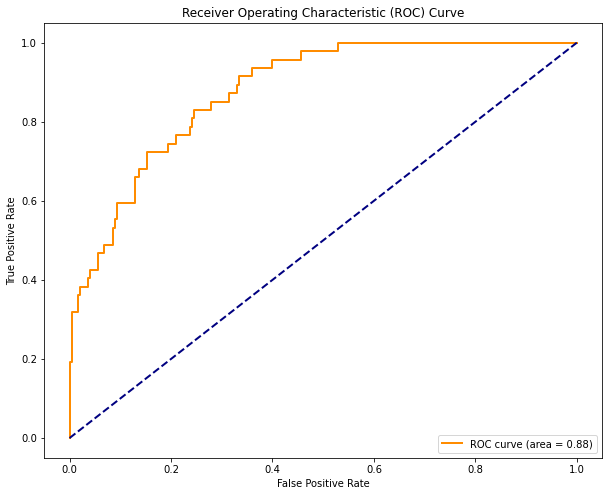

In [10]:
pipe_svc = Pipeline([("prepper", coltrans),
                     ("selector", selection),
                     ("estimator", svc)])

pipe_svc = GridSearchCV(estimator=pipe_svc,
                        param_grid=search_space,
                        scoring=f2(),
                        cv=6,
                        verbose=3,
                        n_jobs=-1)
pipe_svc.fit(Xtrain, ytrain)
#model_svc = pipe_svc.best_estimator_
#print(grid_svc.best_estimator_)
print(pipe_svc.best_params_)
print(f"Best F score: {pipe_svc.best_score_.mean():.2%}")
print("--------------------------------------------------------")
ypred = pipe_svc.predict(Xtest)
print(f"F2 score on test set:\t{f2_score(ytest, ypred):.2%}")
print(f"Recall on test set:\t{recall_score(ytest, ypred):.2%}")
print(f"Precision on test set:\t{precision_score(ytest, ypred):.2%}")
plot_roc(pipe_svc, Xtest, ytest)

In [11]:
results = pd.DataFrame(pipe_svc.cv_results_).sort_values(by="mean_test_score", ascending=False).head(8)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__degree,param_estimator__gamma,param_estimator__kernel,param_selector__percentile,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
272,0.495692,0.023221,0.024218,0.003054,1,2,auto,sigmoid,100,"{'estimator__C': 1, 'estimator__degree': 2, 'e...",0.668449,0.650000,0.662983,0.634921,0.612245,0.741758,0.661726,0.040324,1
314,0.501272,0.019327,0.025265,0.003781,1,3,auto,sigmoid,100,"{'estimator__C': 1, 'estimator__degree': 3, 'e...",0.668449,0.650000,0.662983,0.634921,0.612245,0.741758,0.661726,0.040324,1
271,0.493734,0.019571,0.023034,0.001439,1,2,auto,sigmoid,95,"{'estimator__C': 1, 'estimator__degree': 2, 'e...",0.675676,0.637255,0.646067,0.621762,0.586735,0.726257,0.648959,0.043676,3
313,0.493237,0.018502,0.027881,0.005024,1,3,auto,sigmoid,95,"{'estimator__C': 1, 'estimator__degree': 3, 'e...",0.675676,0.637255,0.646067,0.621762,0.586735,0.726257,0.648959,0.043676,3
312,0.486452,0.015237,0.027101,0.002548,1,3,auto,sigmoid,90,"{'estimator__C': 1, 'estimator__degree': 3, 'e...",0.668449,0.637255,0.649718,0.628272,0.589744,0.714286,0.647954,0.038108,5
270,0.503608,0.009663,0.025757,0.003527,1,2,auto,sigmoid,90,"{'estimator__C': 1, 'estimator__degree': 2, 'e...",0.668449,0.637255,0.649718,0.628272,0.589744,0.714286,0.647954,0.038108,5
265,0.574953,0.029769,0.045740,0.005012,1,2,auto,rbf,100,"{'estimator__C': 1, 'estimator__degree': 2, 'e...",0.646067,0.638889,0.628743,0.632184,0.621469,0.689655,0.642834,0.022311,7
307,0.564749,0.018196,0.047887,0.002232,1,3,auto,rbf,100,"{'estimator__C': 1, 'estimator__degree': 3, 'e...",0.646067,0.638889,0.628743,0.632184,0.621469,0.689655,0.642834,0.022311,7


[Text(0.5, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

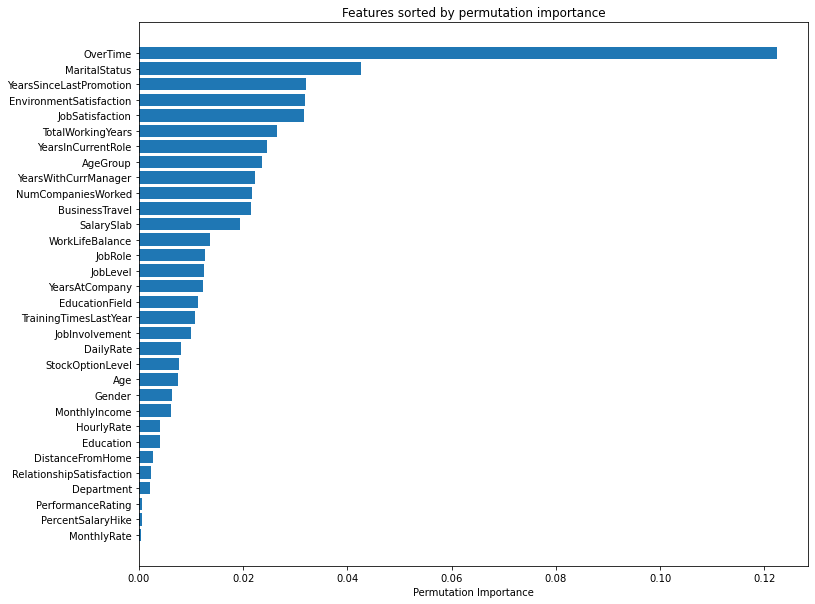

In [12]:
# Estimate feature importance through permutation importance
result = permutation_importance(pipe_svc, Xtrain, ytrain, n_repeats=50, random_state=42)
importance_scores = abs(result.importances_mean)
#pipe_rfc = pipe_rfc.fit(features_train, target_train)
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title="Features sorted by permutation importance",
      xlabel="Permutation Importance")